In [1]:
!pip install -r requirements.txt

  Using cached openai-0.27.8-py3-none-any.whl (73 kB)
  Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 1.4 MB/s eta 0:00:00
  Using cached tenacity-8.2.2-py3-none-any.whl (24 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 KB 25.0 MB/s eta 0:00:00
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.6/335.6 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 KB 13.3 MB/s eta 0:00:00
  Using cached regex-2023.6.3-cp310-cp310-macosx_10_9_x86_64.whl (294 kB)
  Using cached httpx-0.24.1-py3-none-any.whl (75 kB)
  Using cached click-8.1.6-py3-none-any.whl (97 kB)
  Using cached posthog-3.0.1-py2.py3-none-any.whl (37 kB)
  Using cached loguru-0.7.0-py3-none-any.whl (59 kB)
  Using cached pyarrow-12.0.1-cp310-cp310-macosx_10_14_x86_64.whl (24.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━

In [18]:
%%writefile summarization.py

import io
import concurrent
from typing import Generator

import openai
import tiktoken
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm import tqdm

from hamilton.function_modifiers import config


def summarize_chunk_of_text_prompt(content_type: str = "an academic paper") -> str:
    """Base prompt for summarizing chunks of text."""
    return f"Summarize this text from {content_type}. Extract any key points with reasoning.\n\nContent:"


def summarize_text_from_summaries_prompt(content_type: str = "an academic paper") -> str:
    """Prompt for summarizing a paper from a list of summaries."""
    return f"""Write a summary collated from this collection of key points extracted from {content_type}.
    The summary should highlight the core argument, conclusions and evidence, and answer the user's query.
    User query: {{query}}
    The summary should be structured in bulleted lists following the headings Core Argument, Evidence, and Conclusions.
    Key points:\n{{results}}\nSummary:\n"""


@config.when(file_type="pdf")
def raw_text(pdf_source: io.BufferedReader) -> str:
    """Takes a filepath to a PDF and returns a string of the PDF's contents
    :param pdf_source: Series of filepaths to PDFs
    :return: Series of strings of the PDFs' contents
    """
    reader = PdfReader(pdf_source)
    _pdf_text = ""
    page_number = 0
    for page in reader.pages:
        page_number += 1
        _pdf_text += page.extract_text() + f"\nPage Number: {page_number}"
    return _pdf_text


def _create_chunks(text: str, n: int, tokenizer: tiktoken.Encoding) -> Generator[str, None, None]:
    """Helper function. Returns successive n-sized chunks from provided text.
    Split a text into smaller chunks of size n, preferably ending at the end of a sentence
    :param text:
    :param n:
    :param tokenizer:
    :return:
    """
    tokens = tokenizer.encode(text)
    i = 0
    while i < len(tokens):
        # Find the nearest end of sentence within a range of 0.5 * n and 1.5 * n tokens
        j = min(i + int(1.5 * n), len(tokens))
        while j > i + int(0.5 * n):
            # Decode the tokens and check for full stop or newline
            chunk = tokenizer.decode(tokens[i:j])
            if chunk.endswith(".") or chunk.endswith("\n"):
                break
            j -= 1
        # If no end of sentence found, use n tokens as the chunk size
        if j == i + int(0.5 * n):
            j = min(i + n, len(tokens))
        yield tokens[i:j]
        i = j


def chunked_text(
    raw_text: str, max_token_length: int = 1500, tokenizer_encoding: str = "cl100k_base"
) -> list[str]:
    """Chunks the pdf text into smaller chunks of size max_token_length.
    :param pdf_text: the Series of individual pdf texts to chunk.
    :param max_token_length: the maximum length of tokens in each chunk.
    :param tokenizer_encoding: the encoding to use for the tokenizer.
    :return: Series of chunked pdf text. Each element is a list of chunks.
    """
    tokenizer = tiktoken.get_encoding(tokenizer_encoding)
    _encoded_chunks = _create_chunks(raw_text, max_token_length, tokenizer)
    _decoded_chunks = [tokenizer.decode(chunk) for chunk in _encoded_chunks]
    return _decoded_chunks


@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def _summarize_chunk(content: str, template_prompt: str, openai_gpt_model: str) -> str:
    """This function applies a prompt to some input content. In this case it returns a summarized chunk of text.
    :param content: the content to summarize.
    :param template_prompt: the prompt template to use to put the content into.
    :param openai_gpt_model: the openai gpt model to use.
    :return: the response from the openai API.
    """
    prompt = template_prompt + content
    response = openai.ChatCompletion.create(
        model=openai_gpt_model, messages=[{"role": "user", "content": prompt}], temperature=0
    )
    return response["choices"][0]["message"]["content"]


def summarized_chunks(
    chunked_text: list[str], summarize_chunk_of_text_prompt: str, openai_gpt_model: str
) -> str:
    """Summarizes a series of chunks of text.
    Note: this takes the first result from the top_n_related_articles series and summarizes it. This is because
    the top_n_related_articles series is sorted by relatedness, so the first result is the most related.
    :param top_n_related_articles: series with each entry being a list of chunks of text for an article.
    :param summarize_chunk_of_text_prompt:  the prompt to use to summarize each chunk of text.
    :param openai_gpt_model: the openai gpt model to use.
    :return: a single string of each chunk of text summarized, concatenated together.
    """
    _summarized_text = ""
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(chunked_text)) as executor:
        futures = [
            executor.submit(
                _summarize_chunk, chunk, summarize_chunk_of_text_prompt, openai_gpt_model
            )
            for chunk in chunked_text
        ]
        with tqdm(total=len(chunked_text)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        for future in futures:
            data = future.result()
            _summarized_text += data
    return _summarized_text


def prompt_and_text_content(
    summarize_text_from_summaries_prompt: str, user_query: str, summarized_chunks: str
) -> str:
    """Creates the prompt for summarizing the text from the summarized chunks of the pdf.
    :param summarize_text_from_summaries_prompt: the template to use to summarize the chunks.
    :param user_query: the original user query.
    :param summarized_chunks: a long string of chunked summaries of a file.
    :return: the prompt to use to summarize the chunks.
    """
    return summarize_text_from_summaries_prompt.format(query=user_query, results=summarized_chunks)


def summarized_text(
    prompt_and_text_content: str,
    openai_gpt_model: str,
) -> str:
    """Summarizes the text from the summarized chunks of the pdf.
    :param prompt_and_text_content: the prompt and content to send over.
    :param openai_gpt_model: which openai gpt model to use.
    :return: the string response from the openai API.
    """
    response = openai.ChatCompletion.create(
        model=openai_gpt_model,
        messages=[
            {
                "role": "user",
                "content": prompt_and_text_content,
            }
        ],
        temperature=0,
    )
    return response["choices"][0]["message"]["content"]


Overwriting summarization.py


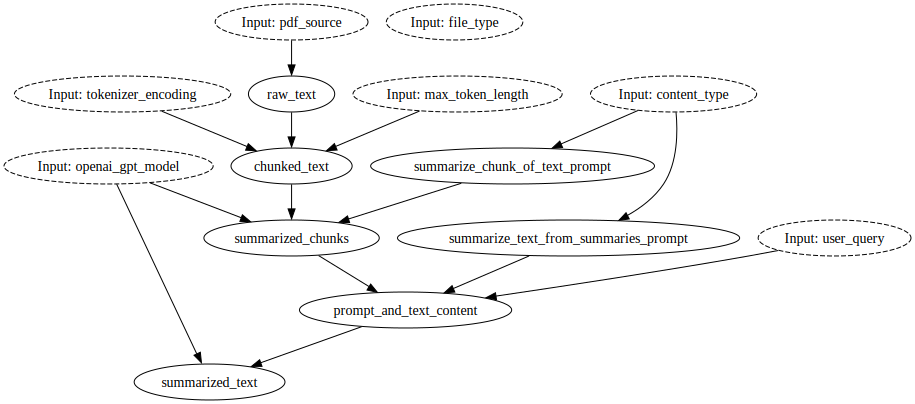

In [19]:
 # run as a script to test Hamilton's execution
import summarization
import importlib
importlib.reload(summarization)

from hamilton import base, driver

dr = driver.Driver(
    {"file_type": "pdf"},
    summarization,
    adapter=base.SimplePythonGraphAdapter(base.DictResult()),
)
dr.display_all_functions(None)

In [20]:
# pull in a pdf
import requests

def download_file(url, filename):
  response = requests.get(url, stream=True)
  if response.status_code == 200:
    with open(filename, 'wb') as fd:
      for chunk in response.iter_content(chunk_size=1024):
        fd.write(chunk)

download_file("https://cdmsworkshop.github.io/2022/Proceedings/ShortPapers/Paper6_StefanKrawczyk.pdf", "hamilton_paper.pdf")

In [27]:
import openai
openai.api_key = "YOUR_KEY_HERE"
with open("hamilton_paper.pdf", "rb") as f:
    result = dr.execute(["summarized_text"], inputs={
        "pdf_source": f,
        "openai_gpt_model": "gpt-3.5-turbo-0613",
        "content_type": "Scientific article",
        "user_query": "Can you ELI5 the paper?"
    })
print(result["summarized_text"])

Core Argument:
- The Hamilton framework is a high-level modeling approach for dataflows that simplifies the user experience for data scientists and provides a unified interface for describing end-to-end dataflows.
- Traditional ETL approaches at Stitch Fix had problems such as poorly documented code, low unit test coverage, limited code reuse, and difficulty in changing underlying infrastructure, which led to the development of the Hamilton framework.

Evidence:
- The Hamilton framework has been used to scale modeling dataflows at Stitch Fix to support over 4000 data transformations without impacting team and user productivity.
- The Hamilton programming paradigm encourages the use of vector computation, improves code readability and documentation, and allows for easy unit testing.
- Hamilton provides decorators to encapsulate operational concerns and reduce repetitive function logic.
- The function DAG is the framework's representation of the nodes that should be executed and the depe